In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [12]:
df = pd.read_csv("data/american_bankruptcy.csv")

# Drop company name (not needed for modeling)
df = df.drop('company_name', axis=1)

# Verify columns
print("Columns in dataset:", df.columns.tolist())
print("\nStatus label distribution:")
print(df['status_label'].value_counts())

Columns in dataset: ['status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']

Status label distribution:
status_label
alive     73462
failed     5220
Name: count, dtype: int64


In [13]:
train = df[df['year'].between(1999, 2011)]
val = df[df['year'].between(2012, 2014)]
test = df[df['year'].between(2015, 2018)]


In [14]:
features = [f'X{i}' for i in range(1, 19)]
X_train, y_train = train[features], train['status_label']
X_val, y_val = val[features], val['status_label']
X_test, y_test = test[features], test['status_label']

In [15]:
print("\nBefore SMOTE:", pd.Series(y_train).value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", pd.Series(y_train_res).value_counts())


Before SMOTE: status_label
alive     51485
failed     4442
Name: count, dtype: int64
After SMOTE: status_label
alive     51485
failed    51485
Name: count, dtype: int64


In [16]:
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    max_depth=5
)
model.fit(X_train_res, y_train_res)


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
                       random_state=42)

In [17]:
def evaluate(model, X, y, set_name):
    print(f"\n{set_name} Results:")
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    print(classification_report(y, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y, y_proba):.3f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances}) \
                .sort_values('Importance', ascending=False)
    sns.barplot(data=feat_imp, x='Importance', y='Feature')
    plt.title(f"{set_name} - Feature Importance")
    plt.show()


Training Results:
              precision    recall  f1-score   support

       alive       0.69      0.68      0.68     51485
      failed       0.68      0.70      0.69     51485

    accuracy                           0.69    102970
   macro avg       0.69      0.69      0.69    102970
weighted avg       0.69      0.69      0.69    102970

AUC-ROC: 0.753


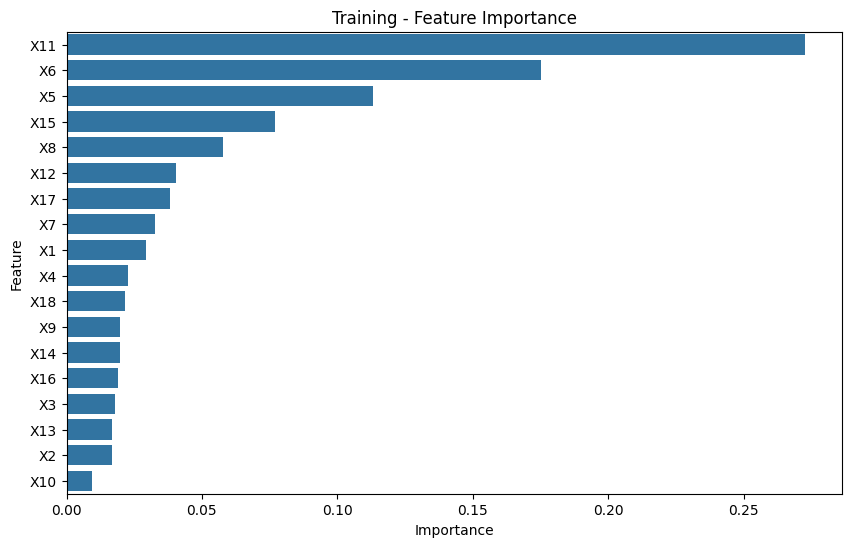


Validation Results:
              precision    recall  f1-score   support

       alive       0.97      0.72      0.83      9982
      failed       0.10      0.60      0.17       491

    accuracy                           0.71     10473
   macro avg       0.53      0.66      0.50     10473
weighted avg       0.93      0.71      0.80     10473

AUC-ROC: 0.725


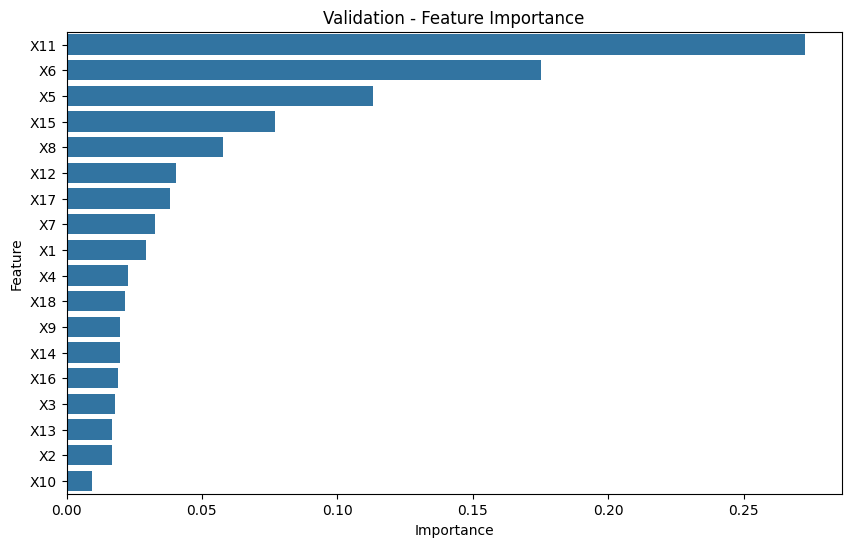


Test Results:
              precision    recall  f1-score   support

       alive       0.99      0.68      0.81     11995
      failed       0.05      0.67      0.09       287

    accuracy                           0.68     12282
   macro avg       0.52      0.68      0.45     12282
weighted avg       0.97      0.68      0.79     12282

AUC-ROC: 0.744


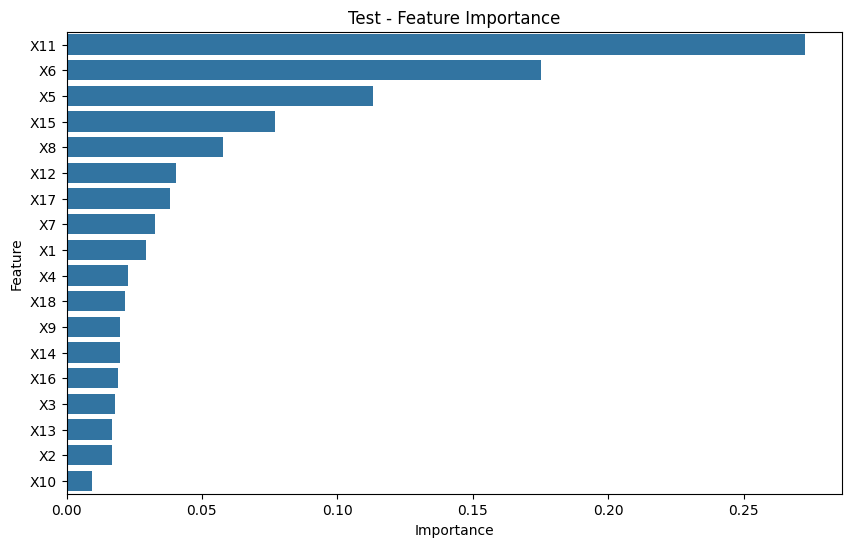

In [18]:
evaluate(model, X_train_res, y_train_res, "Training")
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

In [20]:
sample = X_test.iloc[:1]  # First test sample
print("\nSample Prediction:")
print(f"Features:\n{sample}")
print(f"Prediction: {'Bankrupt' if model.predict(sample)[0] == 1 else 'Healthy'}")
print(f"Probability: {model.predict_proba(sample)[0][1]:.2%}")



Sample Prediction:
Features:
       X1      X2    X3     X4     X5    X6     X7        X8      X9     X10  \
16  873.1  1354.9  70.8  136.9  563.7  47.7  242.7  842.5112  1662.6  1442.1   

      X11   X12    X13    X14    X15     X16    X17     X18  
16  136.1  66.1  307.7  329.0  637.2  1662.6  576.3  1525.7  
Prediction: Healthy
Probability: 36.89%
